# LoRa Transmission Data Analysis

This notebook analyses lora transmission data collected at the Ol Pejeta Conservancy between the 19th and 20th of September. The aim of the data collection exercise was to determine transmission range of the lora enabled sensors within the conservancy and to test the deployment of river level monitoring sensors along the Ewaso Nyiro River.

There are two LoRa gateways mounted at Ol Pejeta House. A Kerlink Gateway at approximately 16m and a Lorix One gateway at approximately 13m.

We deployed three mdot based lora devices at various locations within the conservancy. We used the Maxbotix ultrasonic range sensor with a range of 6m to determine the depth of the Ewaso Nyiro.

The devices and gateway are registered on the Things Network and we use a custom script based on TTN's python SDK to retrive the data and write it to an Influx Database. We store radio propagation parameters including RSSI, SNR and datarate. We vary the datarate between DR0-DR6 and transmit every minute.


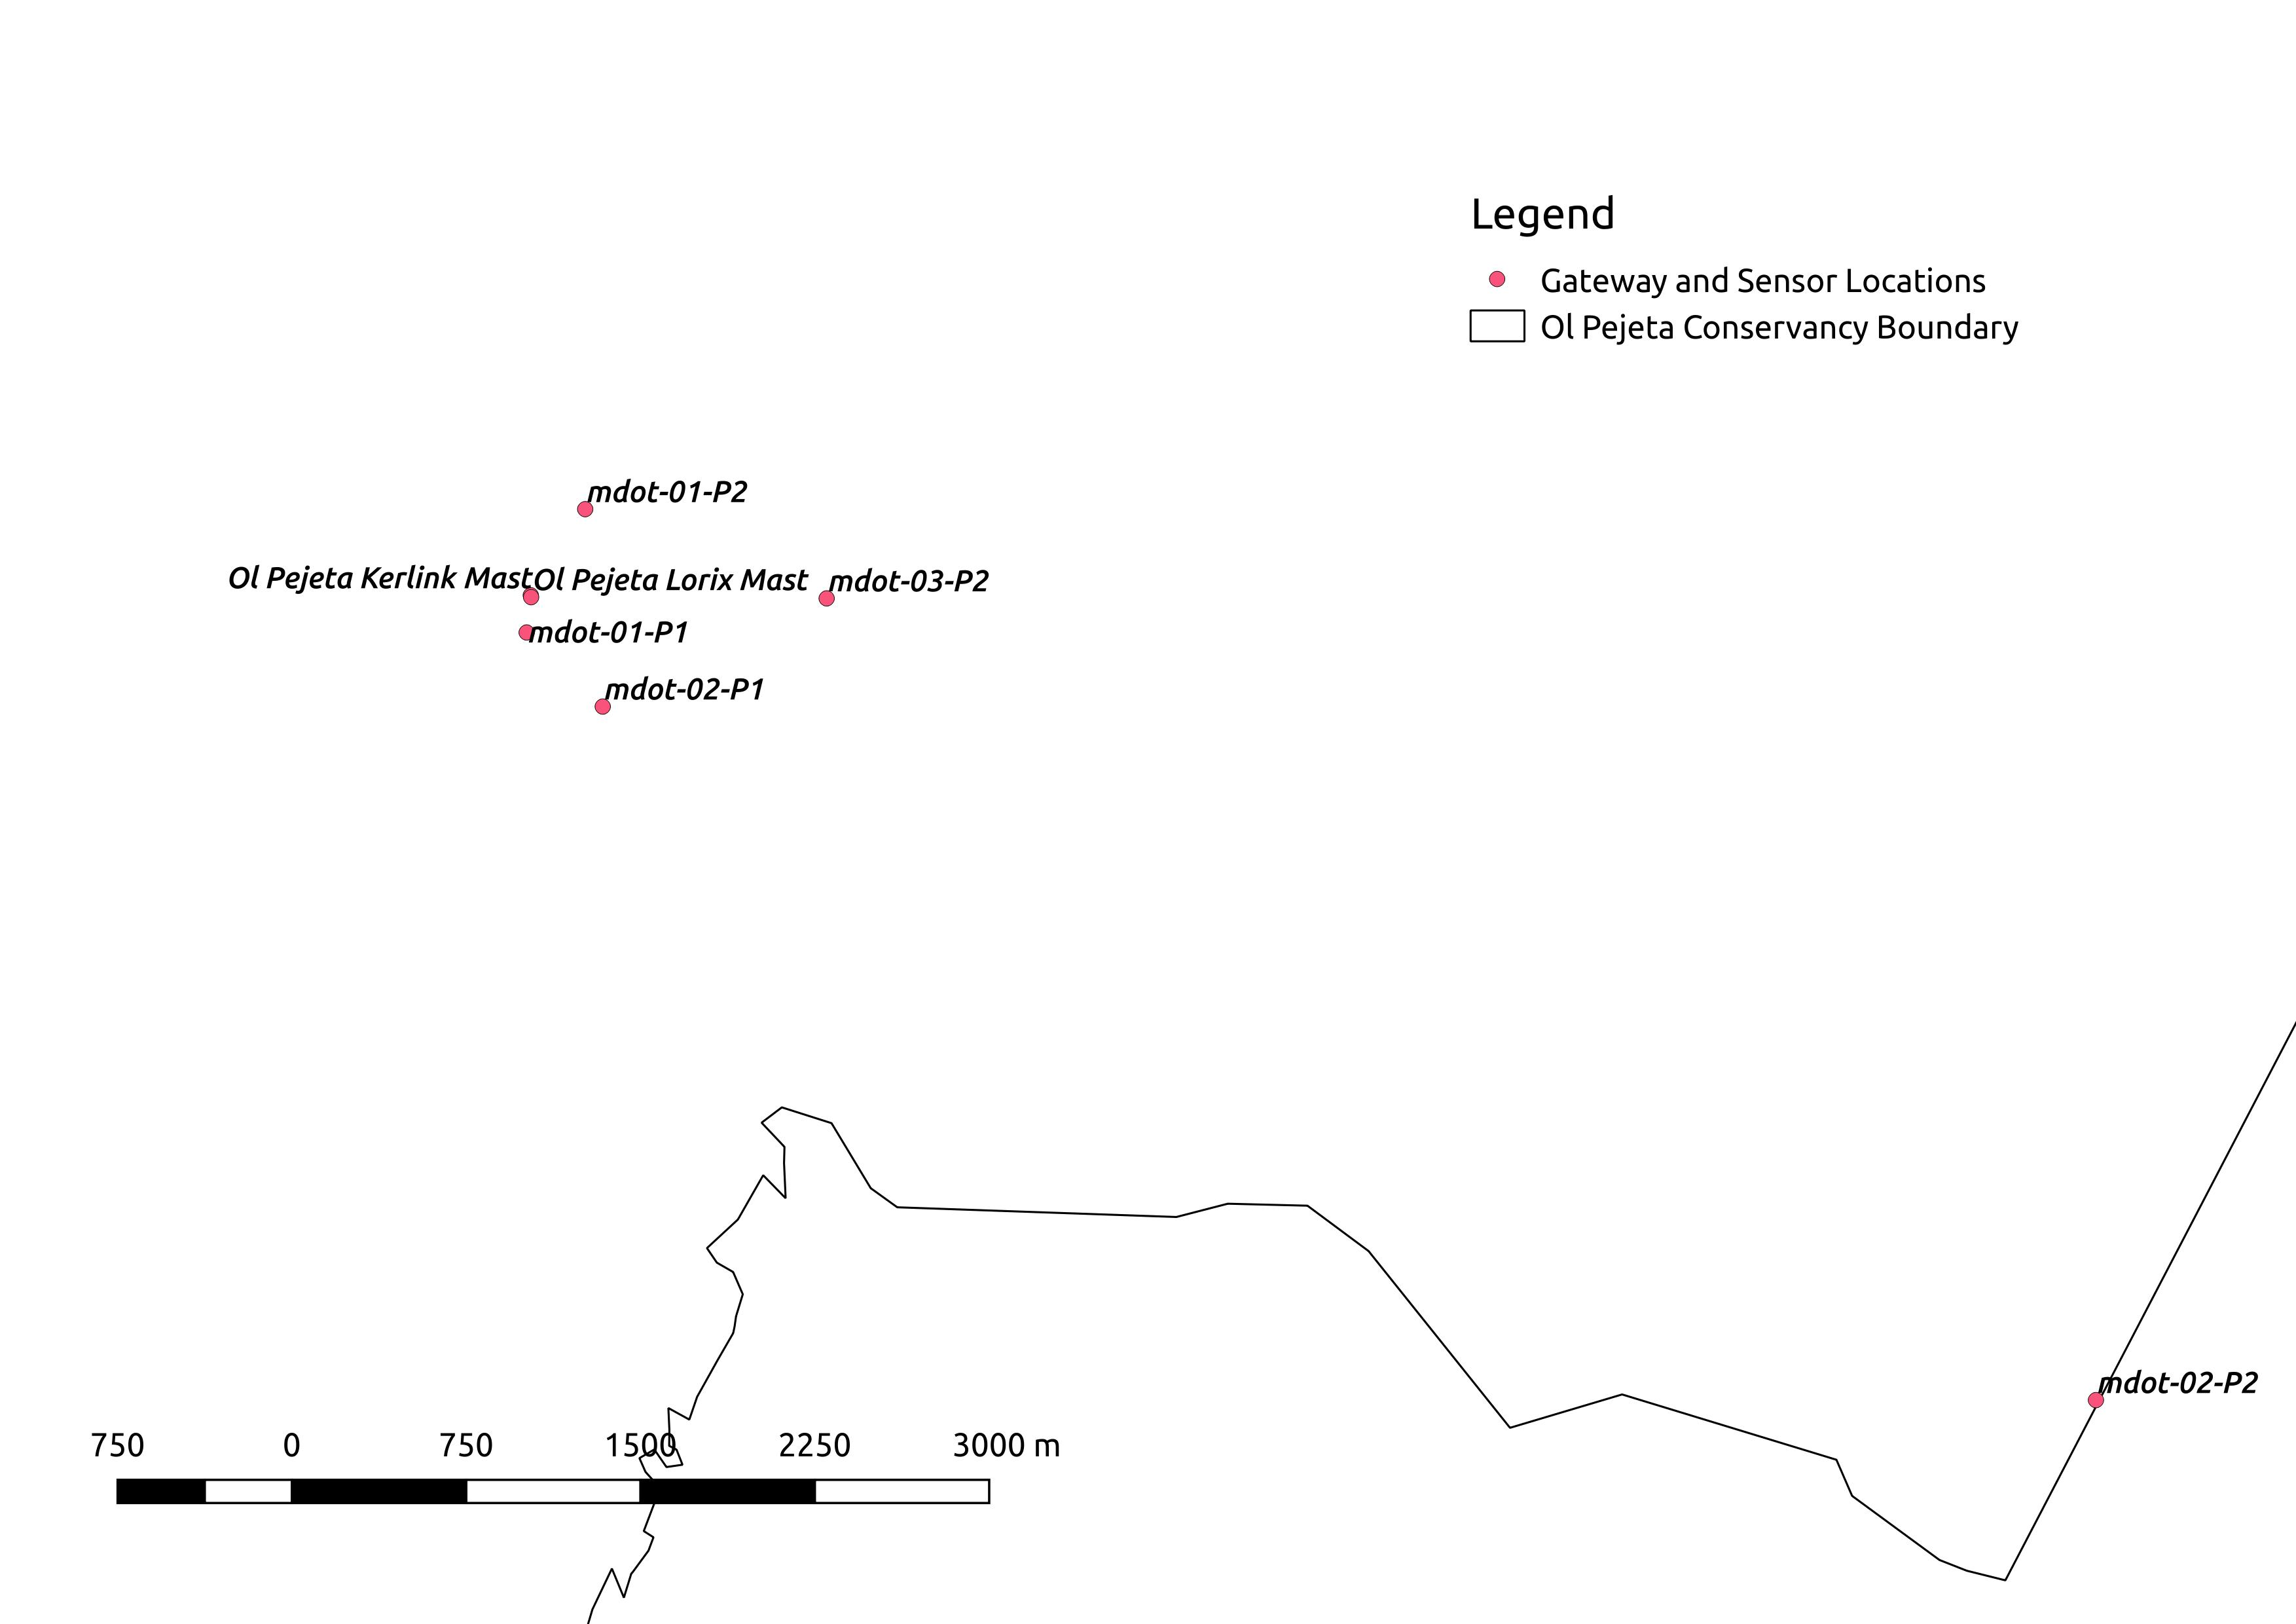

In [1]:
from IPython.display import Image
Image(filename='map.jpg',width=700, height=400)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from pandas.io.json import json_normalize
from influxdb import InfluxDBClient
from datetime import datetime, timedelta, timezone
from geopy.distance import geodesic
from tabulate import tabulate

ModuleNotFoundError: No module named 'geopy'

In [3]:
# Compute distances from points to gateways

kerlink_loc = (0.026884535, 36.903187)
lorix_loc = (0.026812032, 36.9032)

mdot_01_p1_loc = (0.025448333, 36.903027)
mdot_02_p1_loc = (0.022585, 36.905968)

mdot_01_p2_loc = (0.0302132, 36.90529)
mdot_02_p2_loc = (-0.0042156363, 36.963684)
mdot_03_p2_loc = (0.026764926, 36.914623)

sensors = ['mdot-01-P1','mdot-02-P1', 'mdot-01-P2','mdot_02_P2','mdot_03_P3']
sensor_locs = [mdot_01_p1_loc, mdot_02_p1_loc,mdot_01_p2_loc,mdot_02_p2_loc, mdot_03_p2_loc]
kerlink_dist = []

for sl in sensor_locs:
    kerlink_dist.append([sensors[sensor_locs.index(sl)], geodesic(kerlink_loc, sl).km])
    
print(tabulate(kerlink_dist, ['\nSensor', '\nDistance_Kerlink (km)']))  

lorix_dist = []

for sl in sensor_locs:
    lorix_dist.append([sensors[sensor_locs.index(sl)],geodesic(lorix_loc, sl).km])
    
print(tabulate(lorix_dist, ['\n Sensor', '\nDistance_Lorix(km)']))


Sensor        Distance_Kerlink (km)
----------  -----------------------
mdot-01-P1                 0.159803
mdot-02-P1                 0.567329
mdot-01-P2                 0.436207
mdot_02_P2                 7.5617
mdot_03_P3                 1.27312

 Sensor       Distance_Lorix(km)
----------  --------------------
mdot-01-P1              0.152015
mdot-02-P1              0.55983
mdot-01-P2              0.44223
mdot_02_P2              7.55677
mdot_03_P3              1.27161


In [2]:
df = pd.read_csv (r'C:\Users\nahsh\desktop\ISTpaper\data\ol-pejeta-data.csv')

In [3]:
df

,Unnamed: 0,time,Data,airtime,coding_rate,data_rate,frequency,gateway,rssi,sensor,snr
0,0,2019-09-18 09:06:46.620580864+00:00,28,164864000,4/5,SF9BW125,868.5,iot-mashinani,-21,mdot-two,7.50
1,1,2019-09-18 09:08:48.794948096+00:00,28,82432000,4/5,SF8BW125,868.1,iot-mashinani,-21,mdot-two,9.75
2,2,2019-09-18 09:14:54.521569024+00:00,27,1155072000,4/5,SF12BW125,868.3,eui-0002fcc23d0b760a,-82,mdot-two,7.50
3,3,2019-09-18 09:14:54.521569024+00:00,27,1155072000,4/5,SF12BW125,868.3,iot-mashinani,-23,mdot-two,8.75
4,4,2019-09-18 09:16:57.717972992+00:00,27,659456000,4/5,SF11BW125,868.3,eui-0002fcc23d0b760a,-71,mdot-two,10.00
...,...,...,...,...,...,...,...,...,...,...,...
7445,7445,2019-11-11 11:20:13.344456960+00:00,1120,1155072000,4/5,SF12BW125,868.3,eui-7276ff00080e0675,-98,mdot-one,7.00
7446,7446,2019-11-11 11:50:16.676776960+00:00,1120,1155072000,4/5,SF12BW125,868.5,eui-0002fcc23d0b760a,-109,mdot-one,-0.20
7447,7447,2019-11-11 11:50:16.676776960+00:00,1120,1155072000,4/5,SF12BW125,868.5,eui-7276ff00080e0675,-100,mdot-one,6.80
7448,7448,2019-11-11 12:20:20.009406208+00:00,1120,1155072000,4/5,SF12BW125,868.5,eui-0002fcc23d0b760a,-105,mdot-one,1.20


In [4]:
# make time a datetime object
df[['time']] = df[['time']].apply(pd.to_datetime)

In [5]:
df

,Unnamed: 0,time,Data,airtime,coding_rate,data_rate,frequency,gateway,rssi,sensor,snr
0,0,2019-09-18 09:06:46.620580864+00:00,28,164864000,4/5,SF9BW125,868.5,iot-mashinani,-21,mdot-two,7.50
1,1,2019-09-18 09:08:48.794948096+00:00,28,82432000,4/5,SF8BW125,868.1,iot-mashinani,-21,mdot-two,9.75
2,2,2019-09-18 09:14:54.521569024+00:00,27,1155072000,4/5,SF12BW125,868.3,eui-0002fcc23d0b760a,-82,mdot-two,7.50
3,3,2019-09-18 09:14:54.521569024+00:00,27,1155072000,4/5,SF12BW125,868.3,iot-mashinani,-23,mdot-two,8.75
4,4,2019-09-18 09:16:57.717972992+00:00,27,659456000,4/5,SF11BW125,868.3,eui-0002fcc23d0b760a,-71,mdot-two,10.00
...,...,...,...,...,...,...,...,...,...,...,...
7445,7445,2019-11-11 11:20:13.344456960+00:00,1120,1155072000,4/5,SF12BW125,868.3,eui-7276ff00080e0675,-98,mdot-one,7.00
7446,7446,2019-11-11 11:50:16.676776960+00:00,1120,1155072000,4/5,SF12BW125,868.5,eui-0002fcc23d0b760a,-109,mdot-one,-0.20
7447,7447,2019-11-11 11:50:16.676776960+00:00,1120,1155072000,4/5,SF12BW125,868.5,eui-7276ff00080e0675,-100,mdot-one,6.80
7448,7448,2019-11-11 12:20:20.009406208+00:00,1120,1155072000,4/5,SF12BW125,868.5,eui-0002fcc23d0b760a,-105,mdot-one,1.20


# Postion 1

Poistion 1 locations were deployed between 11.30am and 1.30pm on the 19th of September.

In [ ]:
##### start_time = datetime(2019, 9, 19, 8, 30, tzinfo=timezone.utc) # time in utc
stop_time = datetime(2019, 9, 19, 10, 30, tzinfo=timezone.utc) # time in utc

sensors = df.groupby('sensor')

sensor_labels = ['mdot-one', 'mdot-two']

for sensor_label in sensor_labels:
    sensor = sensors.get_group(sensor_label)

    sensor_p1 = sensor[(sensor['time']>=start_time) &
                        (sensor['time']<=stop_time)]

    for label, grp in sensor_p1.groupby('gateway'):
        print(sensor_label, label, np.mean(grp.rssi), np.std(grp.rssi))

# Position 2

In [7]:
start_time = datetime(2019, 9, 19, 15, 0, tzinfo=timezone.utc) # time in utc
stop_time = datetime(2019, 9, 20, 11, 0, tzinfo=timezone.utc) # time in utc

sensors = df.groupby('sensor')

sensor_labels = ['mdot-one', 'mdot-two', 'mdot-03']

for sensor_label in sensor_labels:
    sensor = sensors.get_group(sensor_label)

    sensor_p2 = sensor[(sensor['time']>=start_time) &
                        (sensor['time']<=stop_time)]

    for label, grp in sensor_p2.groupby('gateway'):
        print(sensor_label, label, np.mean(grp.rssi), np.std(grp.rssi))

mdot-one eui-0002fcc23d0b760a -91.57011070110701 3.411191639446461
mdot-one eui-7276ff00080e0675 -93.44380952380952 3.157935546539824
mdot-two eui-0002fcc23d0b760a -104.48523206751055 2.7697875074525213
mdot-two eui-7276ff00080e0675 -117.77874186550976 2.0960823235031554
mdot-03 eui-0002fcc23d0b760a -109.7410071942446 2.221828042146622
mdot-03 eui-7276ff00080e0675 -101.0091743119266 2.79151865164096
